In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 14.2 MB/s 
     |████████████████████████████████| 1.8 MB 63.2 MB/s 
     |████████████████████████████████| 1.2 MB 62.8 MB/s 
     |████████████████████████████████| 181 kB 78.7 MB/s 
     |████████████████████████████████| 145 kB 93.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e83b89c77d31a7816dbd6d8e1572131a526676c467eccbb5f5a68cc329ec9878
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.3 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 84.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-sbert/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 11:54:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="sentence-transformers/stsb-roberta-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=4
    encoder_lr=1.5e-5 #2e-5
    decoder_lr=1.5e-5 #2e-5
    min_lr=5.7e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=14
    fc_dropout=0.1
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train_all_index=20
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-SBERT', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [15]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [16]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [17]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [18]:
train['text'] = '[CLS]' + train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = '[CLS]' + test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]abatement of pollution[SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]act of abating[SEP]HUMAN NE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]active catalyst[SEP]HUMAN N...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]eliminating process[SEP]HUM...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]forest region[SEP]HUMAN NEC...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,[CLS]opc drum[SEP]inorganic photoconductor dru...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,[CLS]adjust gas flow[SEP]altering gas flow[SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,[CLS]lower trunnion[SEP]lower locating[SEP]PER...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,[CLS]cap component[SEP]upper portion[SEP]TEXTI...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,[CLS]neural stimulation[SEP]artificial neural ...


# EDA

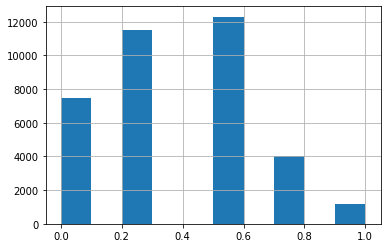

In [19]:
train['score'].hist()

In [20]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [21]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [22]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [23]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [24]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [25]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [26]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

# Dataset

In [27]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [28]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [29]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [30]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            # self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            # self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        # self.fc = nn.Linear(self.config.num_labels, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output



# Helper Functions

In [31]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [32]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Epoch: [1][0/2062] Elapsed 0m 1s (remain 46m 51s) Loss: 0.2316(0.2316) Grad: nan  LR: 0.00000030  
Epoch: [1][100/2062] Elapsed 0m 21s (remain 6m 50s) Loss: 0.2817(0.1624) Grad: 49731.1094  LR: 0.00001500  
Epoch: [1][200/2062] Elapsed 0m 40s (remain 6m 18s) Loss: 0.1326(0.1364) Grad: 19916.1621  LR: 0.00001499  
Epoch: [1][300/2062] Elapsed 1m 0s (remain 5m 54s) Loss: 0.0893(0.1242) Grad: 52844.4141  LR: 0.00001497  
Epoch: [1][400/2062] Elapsed 1m 20s (remain 5m 33s) Loss: 0.0872(0.1122) Grad: 3808.4468  LR: 0.00001493  
Epoch: [1][500/2062] Elapsed 1m 40s (remain 5m 12s) Loss: 0.0682(0.1016) Grad: 10061.6006  LR: 0.00001489  
Epoch: [1][600/2062] Elapsed 2m 0s (remain 4m 51s) Loss: 0.0512(0.0946) Grad: 7680.5562  LR: 0.00001483  
Epoch: [1][700/2062] Elapsed 2m 19s (remain 4m 31s) Loss: 0.0676(0.0891) Grad: 1905.4950  LR: 0.00001477  
Epoch: [1][800/2062] Elapsed 2m 39s (remain 4m 11s) Loss: 0.0608(0.0850) Grad: 2646.3562  LR: 0.00001469  
Epoch: [1][900/2062] Elapsed 2m 59s (remain

Epoch 1 - avg_train_loss: 0.0598  avg_val_loss: 0.1080  time: 479s
Epoch 1 - Score: 0.7178
Epoch 1 - Save Best Score: 0.7178 Model


EVAL: [542/543] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0861(0.1080) 
Epoch: [2][0/2062] Elapsed 0m 0s (remain 16m 10s) Loss: 0.0605(0.0605) Grad: nan  LR: 0.00001288  
Epoch: [2][100/2062] Elapsed 0m 20s (remain 6m 34s) Loss: 0.0450(0.0331) Grad: 31175.1230  LR: 0.00001267  
Epoch: [2][200/2062] Elapsed 0m 40s (remain 6m 12s) Loss: 0.0483(0.0319) Grad: 21196.3633  LR: 0.00001246  
Epoch: [2][300/2062] Elapsed 1m 0s (remain 5m 51s) Loss: 0.0219(0.0310) Grad: 31522.0703  LR: 0.00001224  
Epoch: [2][400/2062] Elapsed 1m 19s (remain 5m 30s) Loss: 0.0084(0.0306) Grad: 15737.8594  LR: 0.00001202  
Epoch: [2][500/2062] Elapsed 1m 39s (remain 5m 10s) Loss: 0.0339(0.0301) Grad: 17471.3887  LR: 0.00001179  
Epoch: [2][600/2062] Elapsed 1m 59s (remain 4m 50s) Loss: 0.0218(0.0297) Grad: 25983.3926  LR: 0.00001155  
Epoch: [2][700/2062] Elapsed 2m 19s (remain 4m 30s) Loss: 0.0193(0.0297) Grad: 21555.2344  LR: 0.00001130  
Epoch: [2][800/2062] Elapsed 2m 39s (remain 4m 10s) Loss: 0.0328(0.0296) Grad:

Epoch 2 - avg_train_loss: 0.0281  avg_val_loss: 0.1074  time: 479s
Epoch 2 - Score: 0.7395
Epoch 2 - Save Best Score: 0.7395 Model


EVAL: [542/543] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0819(0.1074) 
Epoch: [3][0/2062] Elapsed 0m 0s (remain 15m 58s) Loss: 0.0435(0.0435) Grad: nan  LR: 0.00000757  
Epoch: [3][100/2062] Elapsed 0m 20s (remain 6m 37s) Loss: 0.0259(0.0256) Grad: 44978.4453  LR: 0.00000729  
Epoch: [3][200/2062] Elapsed 0m 40s (remain 6m 12s) Loss: 0.0275(0.0252) Grad: 44155.7695  LR: 0.00000700  
Epoch: [3][300/2062] Elapsed 1m 0s (remain 5m 51s) Loss: 0.0291(0.0254) Grad: 24555.2930  LR: 0.00000671  
Epoch: [3][400/2062] Elapsed 1m 19s (remain 5m 30s) Loss: 0.0609(0.0258) Grad: 32025.5605  LR: 0.00000643  
Epoch: [3][500/2062] Elapsed 1m 39s (remain 5m 10s) Loss: 0.0092(0.0252) Grad: 16289.3516  LR: 0.00000614  
Epoch: [3][600/2062] Elapsed 1m 59s (remain 4m 50s) Loss: 0.0575(0.0250) Grad: 27618.8867  LR: 0.00000586  
Epoch: [3][700/2062] Elapsed 2m 19s (remain 4m 30s) Loss: 0.0359(0.0253) Grad: 20518.7012  LR: 0.00000558  
Epoch: [3][800/2062] Elapsed 2m 39s (remain 4m 10s) Loss: 0.0091(0.0252) Grad:

Epoch 3 - avg_train_loss: 0.0246  avg_val_loss: 0.1038  time: 479s
Epoch 3 - Score: 0.7479
Epoch 3 - Save Best Score: 0.7479 Model


EVAL: [542/543] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0783(0.1038) 
Epoch: [4][0/2062] Elapsed 0m 0s (remain 15m 48s) Loss: 0.0179(0.0179) Grad: nan  LR: 0.00000222  
Epoch: [4][100/2062] Elapsed 0m 20s (remain 6m 35s) Loss: 0.0116(0.0221) Grad: 408989.8438  LR: 0.00000202  
Epoch: [4][200/2062] Elapsed 0m 40s (remain 6m 12s) Loss: 0.0256(0.0216) Grad: 28787.3008  LR: 0.00000183  
Epoch: [4][300/2062] Elapsed 1m 0s (remain 5m 51s) Loss: 0.0112(0.0213) Grad: 18908.2793  LR: 0.00000165  
Epoch: [4][400/2062] Elapsed 1m 19s (remain 5m 30s) Loss: 0.0148(0.0219) Grad: 23156.4102  LR: 0.00000147  
Epoch: [4][500/2062] Elapsed 1m 39s (remain 5m 10s) Loss: 0.0174(0.0217) Grad: 12746.8135  LR: 0.00000131  
Epoch: [4][600/2062] Elapsed 1m 59s (remain 4m 49s) Loss: 0.0128(0.0217) Grad: 14335.9502  LR: 0.00000115  
Epoch: [4][700/2062] Elapsed 2m 18s (remain 4m 29s) Loss: 0.0198(0.0215) Grad: 25258.7246  LR: 0.00000100  
Epoch: [4][800/2062] Elapsed 2m 38s (remain 4m 9s) Loss: 0.0410(0.0218) Grad:

Epoch 4 - avg_train_loss: 0.0221  avg_val_loss: 0.1037  time: 478s
Epoch 4 - Score: 0.7497
Epoch 4 - Save Best Score: 0.7497 Model


EVAL: [542/543] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0764(0.1037) 


========== fold: 0 result ==========
Score: 0.7497
========== fold: 1 training ==========


Epoch: [1][0/2105] Elapsed 0m 0s (remain 27m 21s) Loss: 0.7251(0.7251) Grad: nan  LR: 0.00000030  
Epoch: [1][100/2105] Elapsed 0m 20s (remain 6m 51s) Loss: 0.1567(0.1907) Grad: 47008.6133  LR: 0.00001500  
Epoch: [1][200/2105] Elapsed 0m 40s (remain 6m 24s) Loss: 0.0926(0.1378) Grad: 17826.6523  LR: 0.00001499  
Epoch: [1][300/2105] Elapsed 1m 0s (remain 6m 1s) Loss: 0.0636(0.1165) Grad: 29942.6934  LR: 0.00001497  
Epoch: [1][400/2105] Elapsed 1m 20s (remain 5m 40s) Loss: 0.0797(0.1128) Grad: 4367.6670  LR: 0.00001494  
Epoch: [1][500/2105] Elapsed 1m 39s (remain 5m 19s) Loss: 0.0811(0.1105) Grad: 8019.8970  LR: 0.00001489  
Epoch: [1][600/2105] Elapsed 1m 59s (remain 4m 59s) Loss: 0.0897(0.1073) Grad: 3001.1660  LR: 0.00001484  
Epoch: [1][700/2105] Elapsed 2m 19s (remain 4m 38s) Loss: 0.0668(0.1039) Grad: 2185.2664  LR: 0.00001478  
Epoch: [1][800/2105] Elapsed 2m 38s (remain 4m 18s) Loss: 0.0382(0.1015) Grad: 1301.9016  LR: 0.00001470  
Epoch: [1][900/2105] Elapsed 2m 58s (remain 

Epoch 1 - avg_train_loss: 0.0844  avg_val_loss: 0.1221  time: 481s
Epoch 1 - Score: 0.0499
Epoch 1 - Save Best Score: 0.0499 Model


EVAL: [499/500] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0465(0.1221) 
Epoch: [2][0/2105] Elapsed 0m 0s (remain 16m 37s) Loss: 0.0619(0.0619) Grad: nan  LR: 0.00001288  
Epoch: [2][100/2105] Elapsed 0m 20s (remain 6m 40s) Loss: 0.0510(0.0677) Grad: 3264.6707  LR: 0.00001268  
Epoch: [2][200/2105] Elapsed 0m 40s (remain 6m 19s) Loss: 0.0856(0.0689) Grad: 6679.0317  LR: 0.00001247  
Epoch: [2][300/2105] Elapsed 0m 59s (remain 5m 57s) Loss: 0.0697(0.0685) Grad: 6896.9087  LR: 0.00001225  
Epoch: [2][400/2105] Elapsed 1m 19s (remain 5m 37s) Loss: 0.0845(0.0679) Grad: 31120.3027  LR: 0.00001203  
Epoch: [2][500/2105] Elapsed 1m 39s (remain 5m 17s) Loss: 0.0469(0.0683) Grad: 22886.3750  LR: 0.00001181  
Epoch: [2][600/2105] Elapsed 1m 58s (remain 4m 57s) Loss: 0.0482(0.0684) Grad: 23129.0527  LR: 0.00001157  
Epoch: [2][700/2105] Elapsed 2m 18s (remain 4m 37s) Loss: 0.0606(0.0691) Grad: 20832.7715  LR: 0.00001133  
Epoch: [2][800/2105] Elapsed 2m 38s (remain 4m 17s) Loss: 0.1001(0.0689) Grad: 14

Epoch 2 - avg_train_loss: 0.0691  avg_val_loss: 0.1228  time: 480s
Epoch 2 - Score: 0.0444


EVAL: [499/500] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0463(0.1228) 
Epoch: [3][0/2105] Elapsed 0m 0s (remain 16m 12s) Loss: 0.0834(0.0834) Grad: nan  LR: 0.00000757  
Epoch: [3][100/2105] Elapsed 0m 20s (remain 6m 37s) Loss: 0.0928(0.0668) Grad: 1980.5216  LR: 0.00000729  
Epoch: [3][200/2105] Elapsed 0m 39s (remain 6m 16s) Loss: 0.0678(0.0681) Grad: 13134.1035  LR: 0.00000701  
Epoch: [3][300/2105] Elapsed 0m 59s (remain 5m 56s) Loss: 0.0475(0.0669) Grad: 2060.4250  LR: 0.00000673  
Epoch: [3][400/2105] Elapsed 1m 19s (remain 5m 36s) Loss: 0.0603(0.0674) Grad: 2922.6191  LR: 0.00000645  
Epoch: [3][500/2105] Elapsed 1m 39s (remain 5m 16s) Loss: 0.0672(0.0683) Grad: 16497.4141  LR: 0.00000617  
Epoch: [3][600/2105] Elapsed 1m 58s (remain 4m 57s) Loss: 0.1056(0.0686) Grad: 6455.1040  LR: 0.00000589  
Epoch: [3][700/2105] Elapsed 2m 18s (remain 4m 37s) Loss: 0.0731(0.0685) Grad: 10678.9316  LR: 0.00000562  
Epoch: [3][800/2105] Elapsed 2m 38s (remain 4m 17s) Loss: 0.0793(0.0686) Grad: 246

Epoch 3 - avg_train_loss: 0.0684  avg_val_loss: 0.1266  time: 481s
Epoch 3 - Score: 0.0590
Epoch 3 - Save Best Score: 0.0590 Model


EVAL: [499/500] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0453(0.1266) 
Epoch: [4][0/2105] Elapsed 0m 0s (remain 15m 59s) Loss: 0.1108(0.1108) Grad: nan  LR: 0.00000222  
Epoch: [4][100/2105] Elapsed 0m 20s (remain 6m 39s) Loss: 0.0594(0.0702) Grad: 875.9307  LR: 0.00000203  
Epoch: [4][200/2105] Elapsed 0m 39s (remain 6m 18s) Loss: 0.0685(0.0673) Grad: 2107.7422  LR: 0.00000184  
Epoch: [4][300/2105] Elapsed 0m 59s (remain 5m 57s) Loss: 0.0753(0.0677) Grad: 24606.1719  LR: 0.00000166  
Epoch: [4][400/2105] Elapsed 1m 19s (remain 5m 36s) Loss: 0.0529(0.0681) Grad: 13375.5439  LR: 0.00000149  
Epoch: [4][500/2105] Elapsed 1m 38s (remain 5m 16s) Loss: 0.0789(0.0687) Grad: 11841.2373  LR: 0.00000132  
Epoch: [4][600/2105] Elapsed 1m 58s (remain 4m 56s) Loss: 0.0562(0.0679) Grad: 11704.6982  LR: 0.00000117  
Epoch: [4][700/2105] Elapsed 2m 18s (remain 4m 37s) Loss: 0.0940(0.0684) Grad: 3840.4395  LR: 0.00000102  
Epoch: [4][800/2105] Elapsed 2m 38s (remain 4m 17s) Loss: 0.0826(0.0685) Grad: 131

Epoch 4 - avg_train_loss: 0.0678  avg_val_loss: 0.1239  time: 479s
Epoch 4 - Score: 0.0564


EVAL: [499/500] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0460(0.1239) 


========== fold: 1 result ==========
Score: 0.0590
========== fold: 2 training ==========


Epoch: [1][0/2056] Elapsed 0m 0s (remain 23m 13s) Loss: 0.7002(0.7002) Grad: nan  LR: 0.00000030  
Epoch: [1][100/2056] Elapsed 0m 20s (remain 6m 34s) Loss: 0.0648(0.1670) Grad: 30081.8770  LR: 0.00001500  
Epoch: [1][200/2056] Elapsed 0m 40s (remain 6m 10s) Loss: 0.0941(0.1279) Grad: 49236.0703  LR: 0.00001499  
Epoch: [1][300/2056] Elapsed 0m 59s (remain 5m 48s) Loss: 0.2156(0.1249) Grad: 54898.7109  LR: 0.00001497  
Epoch: [1][400/2056] Elapsed 1m 19s (remain 5m 28s) Loss: 0.1615(0.1224) Grad: 23741.6230  LR: 0.00001493  
Epoch: [1][500/2056] Elapsed 1m 39s (remain 5m 8s) Loss: 0.0355(0.1187) Grad: 1050.8191  LR: 0.00001489  
Epoch: [1][600/2056] Elapsed 1m 58s (remain 4m 48s) Loss: 0.1394(0.1181) Grad: 24875.8379  LR: 0.00001483  
Epoch: [1][700/2056] Elapsed 2m 18s (remain 4m 28s) Loss: 0.0934(0.1150) Grad: 24860.9297  LR: 0.00001477  
Epoch: [1][800/2056] Elapsed 2m 38s (remain 4m 8s) Loss: 0.1123(0.1123) Grad: 22188.3086  LR: 0.00001469  
Epoch: [1][900/2056] Elapsed 2m 58s (rem

Epoch 1 - avg_train_loss: 0.0920  avg_val_loss: 0.1139  time: 477s
Epoch 1 - Score: 0.1087
Epoch 1 - Save Best Score: 0.1087 Model


EVAL: [548/549] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0815(0.1139) 
Epoch: [2][0/2056] Elapsed 0m 0s (remain 15m 52s) Loss: 0.0562(0.0562) Grad: nan  LR: 0.00001288  
Epoch: [2][100/2056] Elapsed 0m 20s (remain 6m 28s) Loss: 0.1002(0.0685) Grad: 6652.8540  LR: 0.00001267  
Epoch: [2][200/2056] Elapsed 0m 40s (remain 6m 9s) Loss: 0.0771(0.0692) Grad: 9193.2949  LR: 0.00001246  
Epoch: [2][300/2056] Elapsed 0m 59s (remain 5m 48s) Loss: 0.0446(0.0683) Grad: 4749.7319  LR: 0.00001224  
Epoch: [2][400/2056] Elapsed 1m 19s (remain 5m 28s) Loss: 0.1066(0.0683) Grad: 3432.1509  LR: 0.00001201  
Epoch: [2][500/2056] Elapsed 1m 39s (remain 5m 7s) Loss: 0.0323(0.0691) Grad: 1689.5166  LR: 0.00001178  
Epoch: [2][600/2056] Elapsed 1m 58s (remain 4m 47s) Loss: 0.0640(0.0681) Grad: 10135.1738  LR: 0.00001154  
Epoch: [2][700/2056] Elapsed 2m 18s (remain 4m 28s) Loss: 0.0923(0.0692) Grad: 2467.4426  LR: 0.00001129  
Epoch: [2][800/2056] Elapsed 2m 38s (remain 4m 8s) Loss: 0.0595(0.0691) Grad: 1126.31

Epoch 2 - avg_train_loss: 0.0706  avg_val_loss: 0.1201  time: 478s
Epoch 2 - Score: 0.2632
Epoch 2 - Save Best Score: 0.2632 Model


EVAL: [548/549] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0783(0.1201) 
Epoch: [3][0/2056] Elapsed 0m 0s (remain 16m 8s) Loss: 0.0775(0.0775) Grad: nan  LR: 0.00000757  
Epoch: [3][100/2056] Elapsed 0m 20s (remain 6m 31s) Loss: 0.0676(0.0646) Grad: 3913.5083  LR: 0.00000728  
Epoch: [3][200/2056] Elapsed 0m 40s (remain 6m 10s) Loss: 0.0713(0.0662) Grad: 14758.1631  LR: 0.00000699  
Epoch: [3][300/2056] Elapsed 0m 59s (remain 5m 49s) Loss: 0.0656(0.0674) Grad: 30054.2891  LR: 0.00000671  
Epoch: [3][400/2056] Elapsed 1m 19s (remain 5m 29s) Loss: 0.0437(0.0680) Grad: 25529.4297  LR: 0.00000642  
Epoch: [3][500/2056] Elapsed 1m 39s (remain 5m 8s) Loss: 0.0509(0.0677) Grad: 5011.6772  LR: 0.00000614  
Epoch: [3][600/2056] Elapsed 1m 59s (remain 4m 48s) Loss: 0.0330(0.0680) Grad: 2159.8323  LR: 0.00000585  
Epoch: [3][700/2056] Elapsed 2m 19s (remain 4m 28s) Loss: 0.0499(0.0684) Grad: 7967.4980  LR: 0.00000557  
Epoch: [3][800/2056] Elapsed 2m 38s (remain 4m 8s) Loss: 0.0534(0.0680) Grad: 13791

Epoch 3 - avg_train_loss: 0.0678  avg_val_loss: 0.1189  time: 479s
Epoch 3 - Score: 0.2943
Epoch 3 - Save Best Score: 0.2943 Model


EVAL: [548/549] Elapsed 1m 11s (remain 0m 0s) Loss: 0.0788(0.1189) 
Epoch: [4][0/2056] Elapsed 0m 0s (remain 15m 56s) Loss: 0.0461(0.0461) Grad: nan  LR: 0.00000222  
Epoch: [4][100/2056] Elapsed 0m 20s (remain 6m 31s) Loss: 0.0408(0.0658) Grad: 4084.7097  LR: 0.00000202  
Epoch: [4][200/2056] Elapsed 0m 40s (remain 6m 12s) Loss: 0.0564(0.0654) Grad: 18316.6035  LR: 0.00000183  
Epoch: [4][300/2056] Elapsed 1m 0s (remain 5m 50s) Loss: 0.0747(0.0675) Grad: 6247.0029  LR: 0.00000164  
Epoch: [4][400/2056] Elapsed 1m 19s (remain 5m 29s) Loss: 0.0743(0.0665) Grad: 4583.3345  LR: 0.00000147  
Epoch: [4][500/2056] Elapsed 1m 39s (remain 5m 9s) Loss: 0.1003(0.0667) Grad: 9761.4180  LR: 0.00000130  
Epoch: [4][600/2056] Elapsed 1m 59s (remain 4m 49s) Loss: 0.0713(0.0668) Grad: 10551.6172  LR: 0.00000114  
Epoch: [4][700/2056] Elapsed 2m 19s (remain 4m 29s) Loss: 0.0734(0.0664) Grad: 42538.1055  LR: 0.00000100  
Epoch: [4][800/2056] Elapsed 2m 38s (remain 4m 9s) Loss: 0.0379(0.0655) Grad: 34877

Epoch 4 - avg_train_loss: 0.0585  avg_val_loss: 0.1151  time: 478s
Epoch 4 - Score: 0.4871
Epoch 4 - Save Best Score: 0.4871 Model


EVAL: [548/549] Elapsed 1m 10s (remain 0m 0s) Loss: 0.0608(0.1151) 


========== fold: 2 result ==========
Score: 0.4871
========== fold: 3 training ==========


Epoch: [1][0/2082] Elapsed 0m 0s (remain 31m 12s) Loss: 2.6367(2.6367) Grad: nan  LR: 0.00000030  
Epoch: [1][100/2082] Elapsed 0m 20s (remain 6m 47s) Loss: 0.0487(0.3299) Grad: 24820.7988  LR: 0.00001500  
Epoch: [1][200/2082] Elapsed 0m 40s (remain 6m 19s) Loss: 0.0503(0.2099) Grad: 34067.4180  LR: 0.00001499  
Epoch: [1][300/2082] Elapsed 1m 0s (remain 5m 56s) Loss: 0.1082(0.1711) Grad: 23505.0508  LR: 0.00001497  
Epoch: [1][400/2082] Elapsed 1m 19s (remain 5m 35s) Loss: 0.0720(0.1515) Grad: 1639.3461  LR: 0.00001493  
Epoch: [1][500/2082] Elapsed 1m 39s (remain 5m 14s) Loss: 0.1443(0.1392) Grad: 21529.8164  LR: 0.00001489  
Epoch: [1][600/2082] Elapsed 1m 59s (remain 4m 54s) Loss: 0.0626(0.1309) Grad: 1167.3785  LR: 0.00001484  
Epoch: [1][700/2082] Elapsed 2m 19s (remain 4m 34s) Loss: 0.1104(0.1240) Grad: 1239.4006  LR: 0.00001477  
Epoch: [1][800/2082] Elapsed 2m 38s (remain 4m 13s) Loss: 0.0986(0.1179) Grad: 2223.1443  LR: 0.00001470  
Epoch: [1][900/2082] Elapsed 2m 58s (remai

Epoch 1 - avg_train_loss: 0.0882  avg_val_loss: 0.1413  time: 479s
Epoch 1 - Score: -0.0086


EVAL: [523/524] Elapsed 1m 7s (remain 0m 0s) Loss: 0.0192(0.1413) 
Epoch: [2][0/2082] Elapsed 0m 0s (remain 16m 15s) Loss: 0.0603(0.0603) Grad: nan  LR: 0.00001288  
Epoch: [2][100/2082] Elapsed 0m 20s (remain 6m 36s) Loss: 0.0638(0.0674) Grad: 42412.9766  LR: 0.00001267  
Epoch: [2][200/2082] Elapsed 0m 39s (remain 6m 12s) Loss: 0.0542(0.0689) Grad: 15497.8770  LR: 0.00001246  
Epoch: [2][300/2082] Elapsed 0m 59s (remain 5m 51s) Loss: 0.0771(0.0682) Grad: 12999.7021  LR: 0.00001225  
Epoch: [2][400/2082] Elapsed 1m 19s (remain 5m 31s) Loss: 0.0717(0.0687) Grad: 3033.0820  LR: 0.00001202  
Epoch: [2][500/2082] Elapsed 1m 38s (remain 5m 11s) Loss: 0.0549(0.0691) Grad: 5158.0762  LR: 0.00001179  
Epoch: [2][600/2082] Elapsed 1m 58s (remain 4m 51s) Loss: 0.0569(0.0688) Grad: 4539.9595  LR: 0.00001156  
Epoch: [2][700/2082] Elapsed 2m 18s (remain 4m 32s) Loss: 0.1162(0.0688) Grad: 16425.6230  LR: 0.00001131  
Epoch: [2][800/2082] Elapsed 2m 37s (remain 4m 12s) Loss: 0.0793(0.0689) Grad: 12

Epoch 2 - avg_train_loss: 0.0676  avg_val_loss: 0.1188  time: 478s
Epoch 2 - Score: 0.0024
Epoch 2 - Save Best Score: 0.0024 Model


EVAL: [523/524] Elapsed 1m 7s (remain 0m 0s) Loss: 0.0087(0.1188) 
Epoch: [3][0/2082] Elapsed 0m 0s (remain 16m 12s) Loss: 0.0612(0.0612) Grad: nan  LR: 0.00000757  
Epoch: [3][100/2082] Elapsed 0m 20s (remain 6m 37s) Loss: 0.0623(0.0674) Grad: 15281.1172  LR: 0.00000728  
Epoch: [3][200/2082] Elapsed 0m 40s (remain 6m 15s) Loss: 0.0659(0.0680) Grad: 21277.4551  LR: 0.00000700  
Epoch: [3][300/2082] Elapsed 0m 59s (remain 5m 53s) Loss: 0.0797(0.0680) Grad: 9960.7080  LR: 0.00000672  
Epoch: [3][400/2082] Elapsed 1m 19s (remain 5m 32s) Loss: 0.0869(0.0668) Grad: 13731.1318  LR: 0.00000643  
Epoch: [3][500/2082] Elapsed 1m 39s (remain 5m 12s) Loss: 0.0565(0.0671) Grad: 11704.0820  LR: 0.00000615  
Epoch: [3][600/2082] Elapsed 1m 58s (remain 4m 52s) Loss: 0.0546(0.0670) Grad: 7120.3193  LR: 0.00000587  
Epoch: [3][700/2082] Elapsed 2m 18s (remain 4m 32s) Loss: 0.0708(0.0673) Grad: 13351.7803  LR: 0.00000560  
Epoch: [3][800/2082] Elapsed 2m 38s (remain 4m 12s) Loss: 0.0866(0.0673) Grad: 1